# Optimizing Zmap for "on-the-fly" text classification
This notebook is the first of two to accompany our [Few-Shot Text Classification](https://few-shot-text-classification.fastforwardlabs.com/) report in which we dive into the ins and outs of latent text embeddings for text classifications in several limited-labeled-data regimes. One such regime is what we call "on-the-fly" text classification in which no labeled data exists. To classify text with no labeled training data we rely on the inherent meaning of the labels themselves and embed both the label name and the text document with Sentence-BERT. Classification proceeds by assiging the label name whose embedding maximizes the cosine similarity to the text document embedding. 

 To enhance the classification accuracy of this method, this notebook focuses on how to optimize a mapping (Zmap) between Sentence-BERT (SBERT) embedding space and word2vec (w2v) embedding space since SBERT is optimized to generate representations for *sentences*, while w2v is optimized for *words*. 

  In the following experiments we use two datasets: AG News and the Reddit dataset, both of which can be found on the [HuggingFace Dataset Repository](link) (CAUTION: the Reddit dataset is *very* large and takes a looooong time to download. In our experiments we have already downsampled the dataset to fit in memory. Details on how we did that can be found in [this](link) notebook.)

### Notes
* This notebook requires the use of the original word2vec embeddings (which take a while to download for the first time)
* Because this notebook makes use of a Transformer model, **GPUs are strongly prefered**. 
* You can access free GPUs by running this notebook with Google Colaboratory, a Jupyter Notebook environment that runs in the browser using Google Cloud. [This introductory Colab](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=K-NVg7RjyeTk) demonstrates how to use Colab with GitHub. 


### Data to upload
* Word2Vec model
* reddit dataset


## Installation in a Colab environment
If you followed the installation instructions in the README and are running this notebook locally or in your CML/CDSW environment, you can skip this section. 

However, if you'd like to take advantage of the free GPUs provided by a Colab environment you'll need to do a bit of Follow the steps below. 

In [ ]:
 # clone the few-shot repo 
 !git clone https://github.com/fastforwardlabs/few-shot-text-classification.git

Move the the `fewshot` subdirectory and the `setup.py` file up from the main `few-shot-text-classification` directory and then run the following cell. 

In [ ]:
!pip3 install datasets==1.1.2
!pip3 install transformers==3.3.0
!pip3 install -e .

## Getting Started

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fewshot.data.loaders import load_or_cache_data

from fewshot.embeddings.word_embeddings import (
    load_word_vector_model,
    get_topk_w2v_vectors,
    get_word_embeddings
)
from fewshot.embeddings.sentence_embeddings import (
    load_transformer_model_and_tokenizer,
    get_sentence_embeddings,
)

from fewshot.models.on_the_fly import OLS_with_l2_regularization

from fewshot.eval import predict_and_score, simple_topk_accuracy

from fewshot.utils import (
    fewshot_filename,
    torch_load,
    torch_save,
    pickle_load,
    pickle_save,
    to_tensor,
    to_list,
)


In [ ]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, tnrange
from torch.utils.data import TensorDataset, DataLoader

from fewshot.embeddings import word_embeddings as w2v
from fewshot.embeddings import transformer_embeddings as transf

from fewshot.predictions import compute_predictions, compute_predictions_projection
from fewshot.metrics import simple_accuracy, simple_topk_accuracy
from fewshot.data.loaders import (
    load_or_cache_data, 
    Dataset,
    _prepare_category_names
)
from fewshot.utils import (
    fewshot_filename, 
    torch_load,
    pickle_load, 
    pickle_save,
    torch_load,
    to_tensor, 
    to_list, 
    torch_save,  
    compute_projection_matrix
)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load a dataset (or three)

In [52]:
# ag news dataset contains `distilbert/sentence_bert` embeddings
news_data = load_or_cache_data("data/agnews", "agnews")

Checking for cached data...


In [66]:
#reddit_data = load_or_cache_data("data", "reddit")

# We're already precomputed the SBERT embeddings for the reddit test set
reddit_data = torch_load(fewshot_filename("data/reddit", "reddit_dataset_1300.pt"))

In [68]:
reddit_data.embeddings

Computing sentence representations:   0%|          | 0/814 [00:03<?, ?it/s]


KeyboardInterrupt: 

# Load SentenceBERT and W2V embedding models

In [54]:
## Load SBERT embedding model
model, tokenizer = load_transformer_model_and_tokenizer("deepset/sentence_bert")

In [55]:
## Load W2V embedding model
w2v_model = load_word_vector_model(small=True) #, cache_dir="data"

# Experiment: How many words should we use to create Zmap? 

For this experiment we'll use the W2V vocabulary, which includes millions of words. As we'll see, we won't need nearly this many to maximize the contribution of Zmap to our latext text classification task. 

### Get SBERT and W2V embedding vectors for the topk words in the W2V vocabulary

We'll use the most frequent words as computed over the corpus that was used to train the w2v embeddings. This was a very large corpus so the most frequent words should be those that are used ... well, frequently!  The assumption is that these common words will create an optimal mapping between SBERT space and W2V space.  

In [58]:
# NOTE: this cell computes SBERT embeddings for thousands of words which are then cached
#       running this cell without a GPU can take several hours!

# Get w2v embeddings and the vocabulary of most frequent words
w2v_vectors, vocabulary = get_topk_w2v_vectors(w2v_model, k=100000, return_word_list=True)
vocabulary_filename = fewshot_filename("my_data/w2v", "w2v_vocab_sbert_embeddings.pt")

try:
    sbert_vectors = torch_load(vocabulary_filename)['embeddings']
except:
    # get sbert embeddings for each word in vocabulary
    sbert_vectors = get_sentence_embeddings(vocabulary, 
                                            model, 
                                            tokenizer, 
                                            output_filename=vocabulary_filename)

We'll compute Z map with *up to* 100,000 words, starting with just 100 words and increasing in steps of 100 to 1000 until we cover the range up to 100,000. 











In [59]:
import numpy as np
num_words = np.concatenate((np.arange(10**2, 10**3, 100), np.arange(10**3, 10**5+990, 1000)))

We'll iterate over the `num_words`, selecting the same words from both the sbert_embeddings and w2v_embeddings. These embeddings will be used to compute Z map. The Z map matrix is then used to compute label predictions for a dataset. The resulting score is stored to an array so we can see how the score changes as a function of the number of words. 

In [60]:
def how_many_words(dataset, num_words):
    num_categories = len(dataset.categories)
    scores = []
    for i in num_words:
        # Use Ordinary Least Squares with l2 regularization to compute Zmap 
        # between the sbert embeddings and w2v embeddings for the first i words
        Zmap = OLS_with_l2_regularization(sbert_vectors[:i], to_tensor(w2v_vectors[:i]))
        
        # Our model (Zmap) is then used as a projection before performing cosine similarity
        # the predict_and_score function wraps this process
        score = predict_and_score(dataset, [Zmap])
        # save the score 
        scores.append(score)
    return scores

In [ ]:
news_scores = how_many_words(news_data, num_words)

In [ ]:
reddit_scores = how_many_words(reddit_data, num_words)

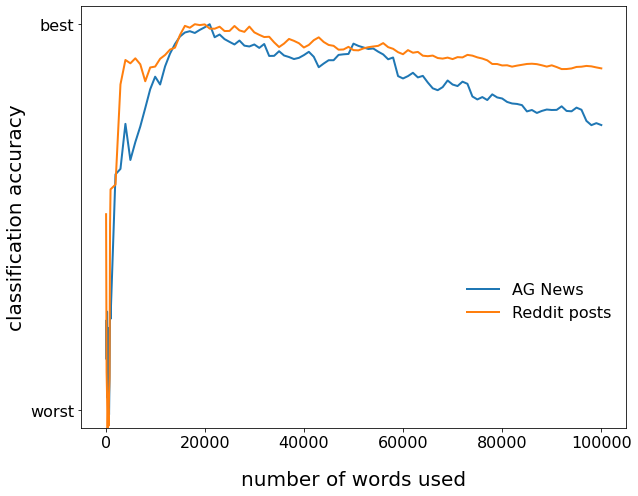

In [61]:
# We've already run this for both agnews and reddit datasets and saved the resulting scores
news_scores = pickle_load(fewshot_filename("my_data", "howmanywords_agnews_scores.pkl"))
reddit_scores = pickle_load(fewshot_filename("my_data","howmanywords_redditcurated_scores.pkl"))

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot()

ax.plot(num_words, np.array(news_scores)/max(news_scores), lw=2, label='AG News');
ax.plot(num_words, np.array(reddit_scores)/max(reddit_scores), lw=2, label='Reddit posts');

ax.set_yticks([0.35, 1])
ax.set_yticklabels(["worst", "best"])
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("number of words used", labelpad=20, fontsize=20)
ax.set_ylabel("classification accuracy", fontsize=20)
ax.set_ylim(.32, 1.03)

plt.legend(loc="right", bbox_to_anchor=(1., 0.3),  frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("Zmaps_howmanywords.png", dpi=150)

As we discussed in detail in the accompanying report, we see that both datasets peak around 20,000 words. Using more words to compute Zmap actually results in worse performance. 

# Experiment: words from the W2V corpus vs words from your specific corpus?

In the previous experiment we used the most frequent words as measured over the vast corpus that the w2v model was trained on, but that's not the only option. Perhaps it's better to use the most frequent words as measured over the dataset you're trying to classify! The intuition here is that words most common to your dataset might provide a better mapping between SBERT and w2v space. 

For this we'll need to set a baseline--in this case, classification performance without using any kind of Zmap. 

### Baseline: SBERT embeddings only
A Zmap can enhance classification accuracy by providing better modeling of individual words making it easier to map sentences to their labels in the embedding space. However, we can use SBERT embeddings only and this will provide a solid baseline to compare for model improvement. 

In [62]:
baseline_news_acc, news_preds = predict_and_score(news_data, linear_maps=None, return_predictions=True)
baseline_news_acc_top3 = simple_topk_accuracy(news_data.labels, news_preds)

print(baseline_news_acc, baseline_news_acc_top3)

51.0921052631579 89.67105263157895


In [63]:
baseline_reddit_acc, reddit_preds = predict_and_score(reddit_data, linear_maps=None, return_predictions=True)
baseline_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(baseline_reddit_acc, baseline_reddit_acc_top3)

/Users/mbeck/Projects/few-shot-text-classification/fewshot/data/utils.py:81: UserWarning: Should run dataset.calc_sbert_embeddings() first.  In the future this will fail.
  "Should run dataset.calc_sbert_embeddings() first.  In the future this will fail."
Computing sentence representations:   0%|          | 0/814 [00:04<?, ?it/s]


KeyboardInterrupt: 

### Zmap: Construct from most frequent words in w2v training corpus

We'll construct a Zmap using the w2v vocabulary consisting of the most frequently used 20,000 words, since we found in the previous section that this provided an optimal Zmap.

In [ ]:
k_words = 20000

# if above cells have already been run, no need to recompute sbert embeddings
try:    
    sbert_vectors_20k = sbert_vectors[:k_words]
    w2v_vectors_20k = to_tensor(w2v_vectors[:k_words])

# otherwise, compute sbert embeddings from the top 20k w2v words
except:
    vocabulary_filename = fewshot_filename("my_data/w2v", "w2v_vocab20k_sbert_embeddings.pt")
    try:
        # Load 20k sbert vectors if we've already created them
        sbert_vectors_20k = torch_load(vocabulary_filename)['embeddings']
    except:
        # get sbert embeddings for each word in vocabulary
        w2v_vectors_20k, vocabulary = get_topk_w2v_vectors(w2v_model, k=k_words, return_word_list=True)
        sbert_vectors_20k = get_sentence_embeddings(vocabulary, 
                                                    model, 
                                                    tokenizer, 
                                                    output_filename=vocabulary_filename)

Zmap_w2v = OLS_with_l2_regularization(sbert_vectors_20k, to_tensor(w2v_vectors[:k_words]))
# We save this Zmap for use in our few-shot application
torch_save(Zmap_w2v, fewshot_filename("data/maps", "Zmap_20k_w2v_words_alpha0.pt"))

In [ ]:
zw2v_news_acc, news_preds = predict_and_score(news_data, linear_maps=[Zmap_w2v], return_predictions=True)
zw2v_news_acc_top3 = simple_topk_accuracy(news_data.labels, news_preds)

print(zw2v_news_acc, zw2v_news_acc_top3)

In [ ]:
zw2v_reddit_acc, reddit_preds = predict_and_score(reddit_data, linear_maps=[Zmap_w2v], return_predictions=True)
zw2v_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(zw2v_reddit_acc, zw2v_reddit_acc_top3)

Using a Zmap constructed from the most frequent 20k words as measured over the corpus that w2v embeddings were trained on definitely improved performance for the AG news dataset (increasing accuracy by nearly 15 points!), but it made our classification worse for the reddit dataset.

word2vec embeddings were trained on 100 billion words of the Google News dataset and the most frequent words are based on the distribution contained with the Google News dataset. It is perhaps not surprising, then, that choosing the most frequent words from a news corpus improves performance on another news corpus. 

Perhaps using the most frequently used words on Reddit will yield a better choice of Zmap for the reddit dataset. 

#### Side Quest: fine-tuning the regularization parameter
Turns out you can increase the performance by about another 5 points depending on the regularization parameter. The drawback, however, is that fine-tuning parameters requires *some*  labeled data in order to properly evaluate between different values. In our experiments we find that values beteen 5 and 12 tend to work best for most datasets. 

In [ ]:
for alpha in [0.1, 1, 5, 10, 15, 20]:
    Zmap = OLS_with_l2_regularization(sbert_vectors_20k, to_tensor(w2v_vectors_20k), alpha=alpha)
    news_acc = predict_and_score(news_data, linear_maps=Zmap, return_predictions=False)
    reddit_acc = predict_and_score(reddit_data, linear_maps=Zmap, return_predictions=False)
    print(f"alpha: {alpha} \t news_acc: {news_acc} \t reddit_acc: {reddit_acc}")

### Zmap: Construct from most frequent words in a specific corpus (e.g., Reddit)

Next, we'll construct a Zmap using the most frequent words as measured over the Reddit dataset. The most common words in the Reddit dataset was explored in [this notebook](https://github.com/fastforwardlabs/few-shot-text-classification/blob/master/notebooks/CreatingRedditDataset.ipynb). 

**This file is not included in the repo so the cells in this section will not run.**

However, we leave these cells in to provide a walk-through of how to perform the analysis. 

In [ ]:
most_common_reddit_words = pickle_load(fewshot_filename("my_data/reddit", "most_common_words.pkl"))

In [ ]:
# not all words have embeddings in the canonical version of w2v
# identify top 20k words in the reddit word list that also have w2v embeddings

w2v_vectors_redditwords, words_not_found = get_word_embeddings(
    most_common_reddit_words['no_punc_no_stop'], 
    w2v_model)

#select the top20k w2v embeddings (corresponding to the top 20k words in common)
w2v_vectors_redditwords = w2v_vectors_redditwords[:20000]

# identify the words in common
words_not_found = set(words_not_found)
common_words = []
for word in most_common_reddit_words['no_punc_no_stop']:
    if word not in words_not_found:
        common_words.append(word)

top20k_common_words = common_words[:20000]

In [ ]:
vocabulary_filename = fewshot_filename("my_data/reddit", "reddit_vocab20k_sbert_embeddings.pt")

try:
    sbert_vectors_redditwords = torch_load(vocabulary_filename)['embeddings']
except: 
    # compute sbert vectors for the top20_common_words
    sbert_vectors_redditwords = get_sentence_embeddings(top20k_common_words, 
                                                        model, 
                                                        tokenizer, 
                                                        output_filename=vocabulary_filename)

In [ ]:
Zmap_redditwords = OLS_with_l2_regularization(sbert_vectors_redditwords, 
                                              to_tensor(w2v_vectors_redditwords))

zred_reddit_acc, reddit_preds = predict_and_score(reddit_data, linear_maps=[Zmap_redditwords], 
                                                  return_predictions=True)
zred_reddit_acc_top3 = simple_topk_accuracy(reddit_data.labels, reddit_preds)

print(zred_reddit_acc, zred_reddit_acc_top3)


Unfortunately, constructing Zmap from a vocabulary of the most frequent words in the Reddit dataset doesn't help; in fact, it hurts performance even more! 

On the bright side, even a small amount of regularization will improve the performance significantly (even if it doesn't outperform using SBERT embeddings alone).  Below, we see that even having `alpha=1` increases the score by 6 points. 

In [ ]:
def fine_tune_alpha(alpha_values, dataset, sbert_vectors, w2v_vectors, verbose=True):
  num_categories = len(dataset.categories)

  for alpha in alpha_values:
    Zmap = compute_projection_matrix(sbert_vectors, 
                                    to_tensor(w2v_vectors), 
                                    alpha=alpha)
    
    acc = predict_and_score(dataset, 
                            num_categories, 
                            Zmap=Zmap, 
                            return_predictions=False)
    if verbose:
      print(f"alpha: {alpha} \t score: {acc}")

In [ ]:
alpha = [0, 0.1, 1, 5, 10, 15]
fine_tune_alpha(alpha, reddit_data, sbert_vectors_redditwords, w2v_vectors_redditwords)

In [ ]:
try:
  Zmap_reddit_opt = torch.load("data/Zmaps/Zmap_20k_reddit_words_alpha10.pt")
except:
  Zmap_redditwords_opt = compute_projection_matrix(sbert_vectors_redditwords, 
                                                  to_tensor(w2v_vectors_redditwords),
                                                  alpha=10)
  torch.save(Zmap_redditwords_opt, "data/Zmap_20k_reddit_words_alpha10.pt")

In [ ]:
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7']

fig = plt.figure(figsize=(8,6))
width = 0.25
plt.bar(np.array([0, 1])-width/2, 
        [baseline_news_acc, baseline_reddit_acc], 
        width=width, 
        color=cldr_colors[0],  
        label='SBERT'
        )
plt.bar(np.array([0, 1])+width/2, 
        [zw2v_news_acc, zw2v_reddit_acc], 
        width=width, 
        color=cldr_colors[1], 
        label='SBERT*Zmap'
        )
plt.xticks([0,1], ['AG News', 'Reddit'], fontsize=16)#
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontsize=20);
plt.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("accuracy_agnews_reddit.png", transparent=True, dpi=150)

# Error analysis

Let's take a closer look at how these datasets are composed to see if we can understand why some (AG News) perform well under a Zmap transformation and other (Reddit) perform worse! 

### Number of labels

The AG News dataset has only four categories, while our subset of Reddit contains posts from 10 different subreddits. 

In [ ]:
news_data.categories

In [ ]:
reddit_data.categories

Additionally, the AG news examples are evenly distributed across the four categories. Not so for the Reddit dataset -- but we can change that.

In [ ]:
np.unique(news_data.labels, return_counts=True)

In [ ]:
np.unique(reddit_data.labels, return_counts=True)

In [ ]:
df = pd.read_csv("data/reddit_subset_test.csv")

In [ ]:
subdf = df[df.category.isin(reddit_data.categories)]

In [ ]:
# sample exactly 1300 from each category
sample = subdf.groupby('category', group_keys=False).apply(
    lambda x: x.sample(min(len(x), 1300), random_state=42)
)

sample['category'] = pd.Categorical(sample.category)
sample['label'] = sample.category.cat.codes

In [ ]:
redditsample_data  = Dataset(
    examples = sample["summary"].tolist(),
    labels = sample.label.tolist(),
    categories = _prepare_category_names(sample))


In [ ]:
redditsample_acc, preds = predict_and_score(reddit_data, #redditsample_data, 
                                            reddit_categories, 
                                            Zmap=None, 
                                            return_predictions=True)
redditsample_acc

In [ ]:
redditsample_acc, preds_zw2v = predict_and_score(reddit_data, #redditsample_data, 
                                                  reddit_categories, 
                                                  Zmap=Zmap_w2v, 
                                                  return_predictions=True)
redditsample_acc

In [ ]:
redditsample_acc, preds_zred = predict_and_score(reddit_data, #redditsample_data, 
                                                  reddit_categories, 
                                                  Zmap=Zmap_redditwords, 
                                                  return_predictions=True)
redditsample_acc

In [ ]:
best = [p.best for p in preds]
best_zw2v = [p.best for p in preds_zw2v]
best_zred = [p.best for p in preds_zred]

In [ ]:
thing, best_counts = np.unique(best, return_counts=True)
_, best_zw2v_counts = np.unique(best_zw2v, return_counts=True)
_, best_zred_counts = np.unique(best_zred, return_counts=True)

In [ ]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

width = .25
ax.barh(np.array(thing)-width,
         best_counts,  
         height=width,
         color=cldr_colors[0],
         label='SBERT'
        )
ax.barh(np.array(thing),
         best_zw2v_counts, 
          
         height=width, 
         color=cldr_colors[1],
         label='SBERT*Zmap (w2v words)'
         )
ax.barh(np.array(thing)+width,
         best_zred_counts,
          
         height=width, 
         color=cldr_colors[2],
         label='SBERT*Zmap (Reddit words)'
         )
ax.set_yticks(thing)
ax.set_yticklabels(reddit_data.categories)
ax.invert_yaxis()
ax.tick_params(axis="both", labelsize=16)
ax.set_xlabel("Examples", fontsize=20);
ax.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("reddit_bycategory.png", transparent=True, dpi=150)

In [ ]:
news_acc, news_preds = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=None, 
                                         return_predictions=True)

news_acc, news_preds_zw2v = predict_and_score(news_data, 
                                         news_categories, 
                                         Zmap=Zmap_w2v, 
                                         return_predictions=True)

news_best = [p.best for p in news_preds]
news_best_zw2v = [p.best for p in news_preds_zw2v]

other_thing, news_best_counts = np.unique(news_best, return_counts=True)
_, news_best_zw2v_counts = np.unique(news_best_zw2v, return_counts=True)

In [ ]:
plt.style.use("seaborn-white")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

width = .25
ax.barh(np.array(other_thing)-width/2, 
        news_best_counts, 
        height=width, 
        color=cldr_colors[0], 
        label='SBERT'
        )
ax.barh(np.array(other_thing)+width/2, 
        news_best_zw2v_counts, 
        height=width, 
        color=cldr_colors[1], 
        label='SBERT*Zmap'
        )

ax.set_yticks(other_thing)
ax.set_yticklabels(news_data.categories)
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=16)
ax.set_xlabel("Examples", fontsize=20)
ax.set_xlim(0, 3800)
ax.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("agnews_bycategory.png", transparent=True, dpi=150)

In [ ]:
sample['category'] = sample['category'].astype('str')
reddit_categories2 = [cat for cat in reddit_data.categories if cat != 'funny']
sample2 = sample.loc[sample.category.isin(reddit_categories2)]

sample2['category'] = pd.Categorical(sample2.category)
sample2['label'] = sample2.category.cat.codes

In [ ]:
redditsample2_data  = Dataset(
    examples = sample2["summary"].tolist(),
    labels = sample2.label.tolist(),
    categories = _prepare_category_names(sample2))

In [ ]:
redditsample_acc, preds = predict_and_score(redditsample2_data, 
                                            len(reddit_categories2), 
                                            Zmap=None, 
                                            return_predictions=True)
redditsample_acc

In [ ]:
redditsample_acc, preds_zw2v = predict_and_score(redditsample2_data, 
                                                  len(reddit_categories2), 
                                                  Zmap=Zmap_w2v, 
                                                  return_predictions=True)
redditsample_acc

In [ ]:
redditsample_acc, preds_zred = predict_and_score(redditsample2_data, 
                                                  len(reddit_categories2), 
                                                  Zmap=Zmap_redditwords, 
                                                  return_predictions=True)
redditsample_acc

In [ ]:
fine_tune_alpha(alpha, redditsample2_data, sbert_vectors_redditwords, w2v_vectors_redditwords)

In [ ]:
fine_tune_alpha(alpha, redditsample2_data, sbert_vectors, w2v_vectors)

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***